# 김기범 데이터 시각화

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# 1. 대회에서 제공하는 Train 데이터셋

In [61]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv("../data/test.csv")

print("train shape >>", train_df.shape)
print("test shape >>", test_df.shape)

train shape >> (52530, 8)
test shape >> (9107, 6)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52530 entries, 0 to 52529
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        52530 non-null  object
 1   input_text                52530 non-null  object
 2   label_text                52530 non-null  object
 3   target                    52530 non-null  int64 
 4   predefined_news_category  52530 non-null  object
 5   annotations               52530 non-null  object
 6   url                       52530 non-null  object
 7   date                      52530 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.2+ MB


In [5]:
train_df.head()

,ID,input_text,label_text,target,predefined_news_category,annotations,url,date
0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,생활문화,3,IT과학,"{'annotators': ['08', '13', '07'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2016.06.30. 오전 10:36
1,ynat-v1_train_00001,어버이날 막따가 흐려저…남부지방 여튼 황사,생활문화,3,생활문화,"{'annotators': ['14', '13', '07'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2016.05.08. 오전 5:25
2,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,생활문화,3,생활문화,"{'annotators': ['14', '13', '07'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2016.05.08. 오전 5:25
3,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,사회,2,IT과학,"{'annotators': ['14', '13', '10'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2016.03.15. 오후 12:00
4,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,사회,2,IT과학,"{'annotators': ['16', '11', '15'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2017.02.28. 오전 9:54


## 1.1 target 분포 보기

In [6]:
train_df['label_text'].value_counts()

label_text
세계      9501
스포츠     8833
정치      8473
경제      7084
생활문화    6608
IT과학    6052
사회      5979
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

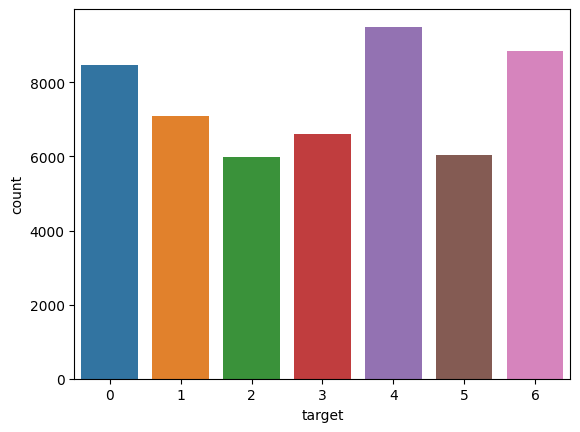

In [7]:
sns.countplot(data=train_df, x='target')

## 1.2 토큰화 진행 후 [PAD] 등장 위치

In [8]:
import gluonnlp as nlp

from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [9]:
### Load Tokenizer and Model ###
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
transform = nlp.data.BERTSentenceTransform(tok, max_seq_length=64, pad=True, pair=False)

using cached model. /opt/ml/data_analysis/.cache/kobert_v1.zip
using cached model. /opt/ml/data_analysis/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /opt/ml/data_analysis/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [10]:
input_text_after_tokenizing = []

for input_text in train_df['input_text'].tolist():
    input_text_after_tokenizing.append(transform([input_text]))

len(input_text_after_tokenizing)

52530

In [11]:
find_pad = []

for x in input_text_after_tokenizing:
    pad_idx = x[0].tolist().index(1)
    find_pad.append(pad_idx)

len(find_pad)

52530

Text(0, 0.5, 'count')

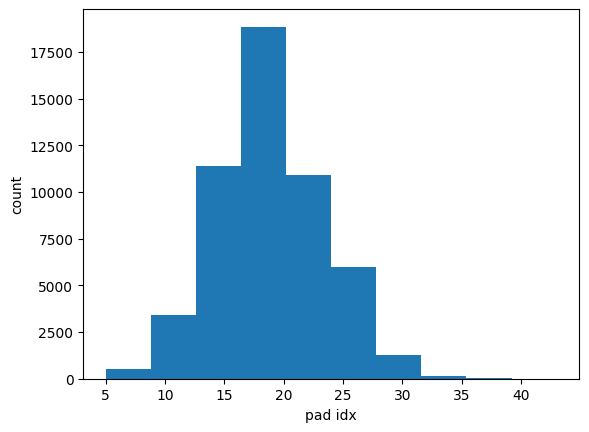

In [12]:
plt.hist(find_pad)
plt.xlabel('pad idx')
plt.ylabel('count')

## 1.3 Label Error 찾기

- annotation과 label_input이 다른 거 찾기

In [13]:
def logic(x):
    x.sort()
    
    return x[0] if x[0] == x[1] else x[1]

train_df['first-scope'] = train_df['annotations'].apply(lambda x: logic(eval(x)['annotations']['first-scope']))

In [14]:
view_df = train_df[train_df['label_text'] != train_df['first-scope']]

len(view_df)

1371

In [15]:
train_df.shape, train_df.drop(view_df.index, axis=0).shape, 52530 - 1371

((52530, 9), (51159, 9), 51159)

- annotaitons 안 쓰고 찾는 방법

In [64]:
train_df.drop_duplicates(inplace=True)

In [65]:
train_df.drop_duplicates(subset=['ID', 'input_text']).shape

(51003, 8)

In [66]:
train_df.duplicated(['ID', 'input_text'], keep=False).value_counts()

False    49632
True      2742
Name: count, dtype: int64

In [72]:
view_df = train_df[train_df.duplicated(['ID', 'input_text'], keep=False)]
view_df.shape

(2742, 8)

In [111]:
train_df.drop(view_df.index, axis=0).shape

(49632, 8)

In [85]:
print(view_df[view_df['label_text'] == view_df['predefined_news_category']].shape)
view_df[view_df['label_text'] == view_df['predefined_news_category']].head(10)

(1178, 8)


,ID,input_text,label_text,target,predefined_news_category,annotations,url,date
282,ynat-v1_train_00250,트럼프·엡스타인 1992년 마러라고서 여성 20여명과 파티,세계,4,세계,"{'annotators': ['09', '18', '11'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2019.07.11. 오전 6:18
361,ynat-v1_train_00316,예스24 우리가 사랑한 24인의 작가들 부산서 전시,생활문화,3,생활문화,"{'annotators': ['02', '15', '12'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2018.01.08. 오전 10:48
392,ynat-v1_train_00341,현대모비스 3연속 100점대 대승…삼성 만난 라건아 39점,스포츠,6,스포츠,"{'annotators': ['18', '02', '03'], 'annotation...",https://sports.news.naver.com/news.nhn?oid=001...,2018.10.19 21:53
409,ynat-v1_train_00354,인공지능에서 구글과 경쟁하려면 데이터 확보 중요,IT과학,5,IT과학,"{'annotators': ['12', '15', '09'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2016.03.20. 오후 12:00
545,ynat-v1_train_00475,獨 언론 극우 AfD 의원 러시아로부터 통제당해,세계,4,세계,"{'annotators': ['18', '07', '03'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2019.04.07. 오후 10:53
553,ynat-v1_train_00482,KB금융 글로벌인프라펀드 5호·6호 투자계약 체결,경제,1,경제,"{'annotators': ['02', '16', '09'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2019.05.28. 오후 6:42
663,ynat-v1_train_00581,월드컵 스웨덴 한국 사전캠프 염탐…인근 건물서 모...,스포츠,6,스포츠,"{'annotators': ['10', '13', '12'], 'annotation...",https://sports.news.naver.com/news.nhn?oid=001...,2018.06.14 05:00
720,ynat-v1_train_00628,엔씨소프트 리니지M 캐릭터 미리 만드세요,IT과학,5,IT과학,"{'annotators': ['03', '12', '15'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2017.05.10. 오후 2:22
741,ynat-v1_train_00647,그래픽 사법개혁안 처리 관련 각 당 입장,정치,0,정치,"{'annotators': ['09', '13', '14'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2019.10.16. 오후 3:31
743,ynat-v1_train_00648,GS건설 전환사채 발행 검토 중,경제,1,경제,"{'annotators': ['03', '09', '14'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2016.04.04. 오전 11:38


In [109]:
view_ID_list = view_df[view_df['label_text'] == view_df['predefined_news_category']]['ID'].values
len(view_ID_list)

1178

In [110]:
view_df[view_df['ID'] == 'ynat-v1_train_00491']

,ID,input_text,label_text,target,predefined_news_category,annotations,url,date
563,ynat-v1_train_00491,영상 미혼남녀 절반 이상 결혼 NO 동거 OK,세계,4,경제,"{'annotators': ['12', '13', '03'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2019.03.22. 오후 5:01
564,ynat-v1_train_00491,영상 미혼남녀 절반 이상 결혼 NO 동거 OK,사회,2,경제,"{'annotators': ['12', '13', '03'], 'annotation...",https://news.naver.com/main/read.nhn?mode=LS2D...,2019.03.22. 오후 5:01


## 1.4 한글 영어 외 다른 문자 찾기

### 1.4.1 자음 여부 확인

In [16]:
train_df['input_text'].str.extract('([ㄱ-ㅎㅏ-ㅣ]+)').value_counts()

Series([], Name: count, dtype: int64)

### 1.4.2 일본어 여부 확인

In [17]:
train_df['input_text'].str.extract('([ぁ-ゔァ-ヴー々〆〤]+)').value_counts()

Series([], Name: count, dtype: int64)

### 1.4.3 한자 여부 확인

In [18]:
train_df['input_text'].str.extract('([一-龥]+)').value_counts()

美    1634
北    1385
朴     812
中     805
日     473
     ... 
大       1
警       1
超       1
史       1
古       1
Name: count, Length: 139, dtype: int64

### 1.4.4 특수문자 확인

In [19]:
train_df['input_text'].str.extract('([^A-Za-z0-9가-힣\sぁ-ゔァ-ヴー々〆〤一-龥]{1,9999})').value_counts()

…      19622
·       5497
.        664
...      511
%        441
       ...  
…女         1
㎒          1
㎏·         1
♥          1
∙          1
Name: count, Length: 98, dtype: int64

In [20]:
print(transform(['…'])[0])
print(transform(['…女'])[0])
print(transform(['㎒'])[0])
print(transform(['㎏·'])[0])
print(transform(['♥'])[0])
print(transform(['꿿'])[0])

[  2 517  55   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1]
[   2  517   55  517 5265    3    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1]
[  2 671 294 459   3   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1]
[  2 517 417 517 478   3   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1  

# 2. AI HUB 뉴시 기사 기계독해 데이터

In [21]:
ai_hub_017 = pd.read_csv("../data/ai_hub_017.csv")

ai_hub_017.shape

(111998, 4)

In [22]:
ai_hub_017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111998 entries, 0 to 111997
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID          111998 non-null  object
 1   input_text  111998 non-null  object
 2   label_text  111998 non-null  object
 3   target      111998 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.4+ MB


## 2.1 target 분포 보기

<Axes: xlabel='target', ylabel='count'>

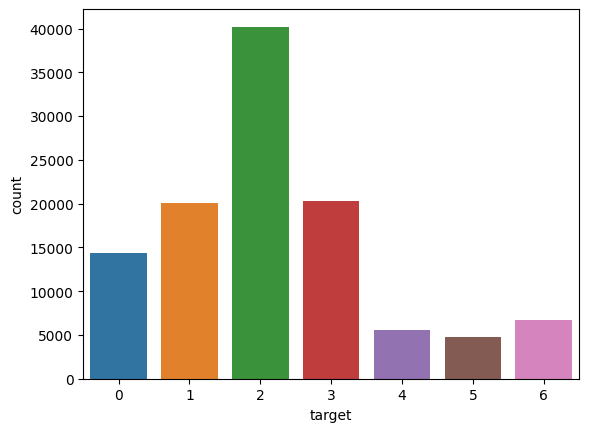

In [23]:
sns.countplot(data=ai_hub_017, x='target')

## 2.2 토크나이징 후에 [PAD] 등장 위치

In [24]:
input_text_after_tokenizing = []

for input_text in ai_hub_017['input_text'].tolist():
    input_text_after_tokenizing.append(transform([input_text]))

len(input_text_after_tokenizing)

111998

In [25]:
find_pad = []

for x in input_text_after_tokenizing:
    try:
        pad_idx = x[0].tolist().index(1)
    except:
        pad_idx = 64
    find_pad.append(pad_idx)

len(find_pad)

111998

Text(0, 0.5, 'count')

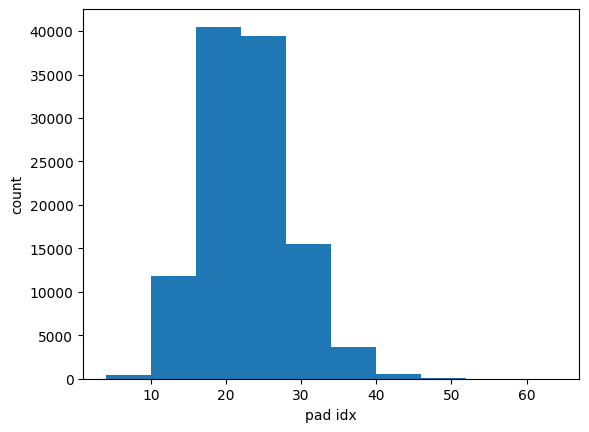

In [26]:
plt.hist(find_pad)
plt.xlabel('pad idx')
plt.ylabel('count')

## 2.3 한글 영어 외 다른 문자 찾기

### 2.3.1 자음 여부 확인

In [27]:
ai_hub_017['input_text'].str.extract('([ㄱ-ㅎㅏ-ㅣ]+)').value_counts()

ㅠㅠ       4
ㅋㅋ       2
ㄱ        1
ㅅ        1
ㅅㅁㄱㄷㄹ    1
ㅈㅂㅈㅇ     1
ㅡ        1
Name: count, dtype: int64

### 2.3.2 일본어 여부 확인

In [28]:
ai_hub_017['input_text'].str.extract('([ぁ-ゔァ-ヴー々〆〤]+)').value_counts()

Series([], Name: count, dtype: int64)

### 2.3.3 한자 여부 확인

In [29]:
ai_hub_017['input_text'].str.extract('([一-龥]+)').value_counts()

美       1558
日        745
文        731
中        550
與        437
        ... 
書風萬里       1
最古         1
木          1
村          1
黨心         1
Name: count, Length: 334, dtype: int64

### 2.3.4 특수문자 확인

In [30]:
ai_hub_017['input_text'].str.extract('([^A-Za-z0-9가-힣\sぁ-ゔァ-ヴー々〆〤一-龥]{1,9999})').value_counts()

,      35781
'      15473
[       9888
"       7659
‘       7496
       ...  
,·‘        1
,“‘        1
“’         1
-'         1
­          1
Name: count, Length: 246, dtype: int64

# 3. 낚시성 기사 탐지 데이터

In [31]:
ai_hub_146 = pd.read_csv("../data/ai_hub_146_val.csv")
ai_hub_146.shape

(111998, 4)

In [32]:
ai_hub_146.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111998 entries, 0 to 111997
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID          111998 non-null  object
 1   input_text  111998 non-null  object
 2   label_text  111998 non-null  object
 3   target      111998 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.4+ MB


## 3.1 target 분포

<Axes: xlabel='target', ylabel='count'>

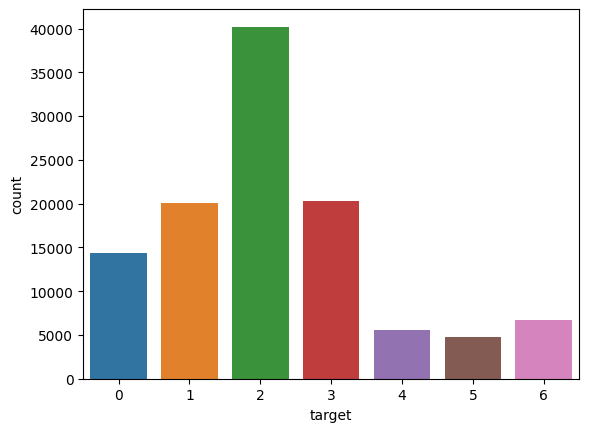

In [33]:
sns.countplot(data=ai_hub_146, x='target')

## 3.2 토크나이징 후에 [PAD] 등장 위치

In [34]:
input_text_after_tokenizing = []

for input_text in ai_hub_146['input_text'].tolist():
    input_text_after_tokenizing.append(transform([input_text]))

len(input_text_after_tokenizing)

111998

In [35]:
find_pad = []

for x in input_text_after_tokenizing:
    try:
        pad_idx = x[0].tolist().index(1)
    except:
        pad_idx = 64
    find_pad.append(pad_idx)

len(find_pad)

111998

Text(0, 0.5, 'count')

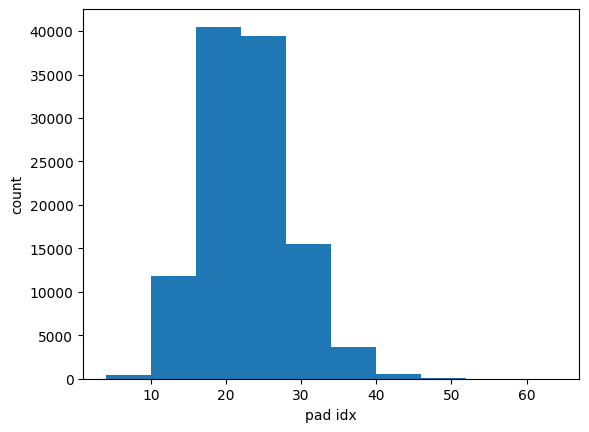

In [36]:
plt.hist(find_pad)
plt.xlabel('pad idx')
plt.ylabel('count')

## 3.3 한글 영어 외 다른 문자 찾기

### 3.3.1 자음 여부 확인

In [37]:
ai_hub_146['input_text'].str.extract('([ㄱ-ㅎㅏ-ㅣ]+)').value_counts()

ㅠㅠ       4
ㅋㅋ       2
ㄱ        1
ㅅ        1
ㅅㅁㄱㄷㄹ    1
ㅈㅂㅈㅇ     1
ㅡ        1
Name: count, dtype: int64

### 3.3.2 일본어 여부 확인

In [38]:
ai_hub_146['input_text'].str.extract('([ぁ-ゔァ-ヴー々〆〤]+)').value_counts()

Series([], Name: count, dtype: int64)

### 3.3.3 한자 여부 확인

In [39]:
ai_hub_146['input_text'].str.extract('([一-龥]+)').value_counts()

美       1558
日        745
文        731
中        550
與        437
        ... 
書風萬里       1
最古         1
木          1
村          1
黨心         1
Name: count, Length: 334, dtype: int64

### 3.3.4 특수문자 확인

In [40]:
ai_hub_146['input_text'].str.extract('([^A-Za-z0-9가-힣\sぁ-ゔァ-ヴー々〆〤一-龥]{1,9999})').value_counts()

,      35781
'      15473
[       9888
"       7659
‘       7496
       ...  
,·‘        1
,“‘        1
“’         1
-'         1
­          1
Name: count, Length: 246, dtype: int64

# 4. AI HUB 데이터끼리 비교

In [41]:
ai_hub_concat = pd.concat([ai_hub_017, ai_hub_146], axis=0)
ai_hub_concat.shape

(223996, 4)

In [45]:
ai_hub_concat.drop_duplicates(subset=['input_text', 'target']).shape, ai_hub_017.shape, ai_hub_146.shape

((110563, 4), (111998, 4), (111998, 4))

In [46]:
ai_hub = ai_hub_concat.drop_duplicates(subset=['input_text', 'target'])
new_data = pd.concat([train_df, ai_hub], axis=0)
new_data.shape

(163093, 9)

In [49]:
new_data.drop_duplicates(subset=['input_text', 'target']).shape, new_data.drop_duplicates(subset=['input_text']).shape

((162937, 9), (161537, 9))

<Axes: xlabel='target', ylabel='count'>

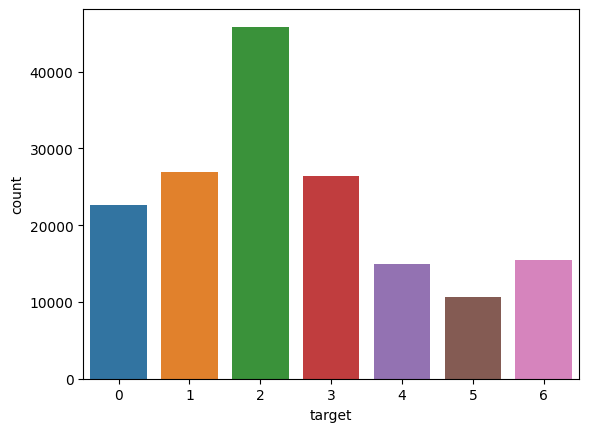

In [48]:
sns.countplot(data=new_data, x='target')

<Axes: xlabel='target', ylabel='count'>

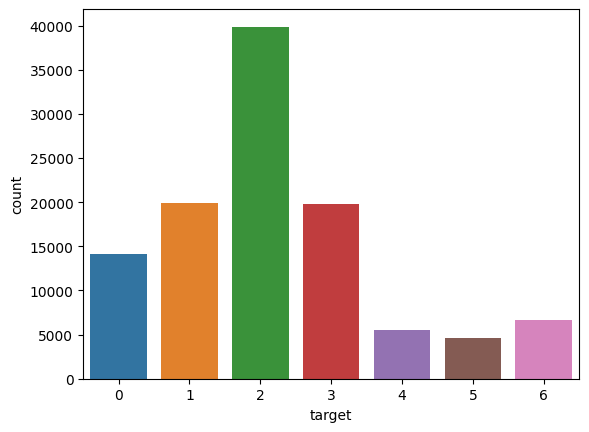

In [50]:
sns.countplot(data=ai_hub, x='target')